In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Library imports.
from pyswmm import Simulation, Links, Output
from swmm.toolkit.shared_enum import LinkAttribute, NodeAttribute, SubcatchAttribute
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import numpy.random as nprnd
from scipy.interpolate import griddata
from sklearn.linear_model import LinearRegression
import time

# Local imports.
from urbansurge import swmm_model, analysis_tools, file_utils

   Depth_node_28  Depth_node_29  Depth_node_31  Depth_node_32  Depth_node_33   
0            0.0            0.0            0.0            0.0            0.0  \
1            0.0            0.0            0.0            0.0            0.0   
2            0.0            0.0            0.0            0.0            0.0   
3            0.0            0.0            0.0            0.0            0.0   
4            0.0            0.0            0.0            0.0            0.0   

   Depth_node_34  Depth_node_35  Depth_node_36  Depth_node_37  Depth_node_38   
0            0.0            0.0            0.0            0.0            0.0  \
1            0.0            0.0            0.0            0.0            0.0   
2            0.0            0.0            0.0            0.0            0.0   
3            0.0            0.0            0.0            0.0            0.0   
4            0.0            0.0            0.0            0.0            0.0   

   ...  Velocity_link_23  Velocity_lin

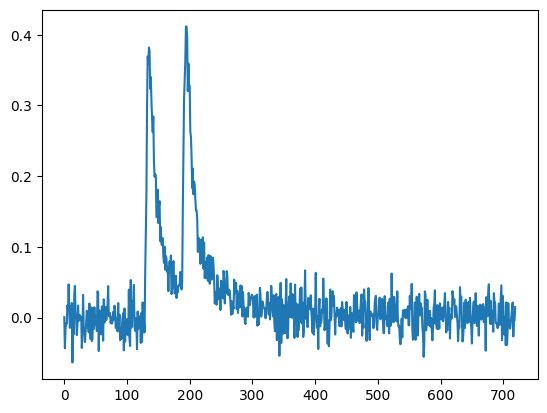

In [56]:
# Load in physical system observation data.
obs_path = r"C:\Users\ay434\Box\Research\Smart_Stormwater\SWMM\Single_Pipe\Output\roughness_23.csv"
obs_df = pd.read_csv(obs_path)
print(obs_df.head())

# Fault indices.
fault_values = obs_df['fault_value'].to_numpy()
fault_idx = np.where(fault_values == 0.03)

# Observed depth.
obs_node = 'Depth_node_36'
obs_depth_all = obs_df[obs_node].to_numpy()
obs_depth = obs_depth_all[fault_idx]

# Add some noise.
obs_depth += np.random.normal(0, 0.02, len(obs_depth))

# Datetime.
datetime = obs_df['datetime']

fig, ax = plt.subplots()
ax.plot(obs_depth)

In [13]:
# Model configuration path.
config_path = r"C:\Users\ay434\Box\Research\Smart_Stormwater\SWMM\Single_Pipe\single_pipe_config.yml"

In [82]:
# Determine the fault parameter using the model every N minutes.
start_dt = datetime[0]

# Number of data chunks.
Nchunk = 20

# Observation period indices.
obs_idx = np.arange(0, len(datetime), len(datetime) // Nchunk)
obs_idx_start = obs_idx[:-1]
obs_idx_end = obs_idx[1:]

# Fault type.
fault_type = 'roughness'

# Fault component.
fault_component = 23

# Fault bounds.
fault_bounds = (0.01, 0.1)

# Grid search locations.
Ngrid = 10
search_locs = np.linspace(fault_bounds[0], fault_bounds[1], Ngrid)

loss = np.zeros((len(obs_idx), len(search_locs)))
for i in range(len(obs_idx_start)):
    print('Chunk', i)
    for j, fault_value in enumerate(search_locs):
        time.sleep(0.5)
        # Create instance of SWMM model.
        swmm = swmm_model.SWMM(config_path)

        # Configure model.
        swmm.configure_model()
        
        if fault_type == 'diameter':
            # Assign fault variables.
            weir_id = fault_component
            offset = fault_value

            # Get initial weir height.
            initial_geometry = swmm.get_weir_geometry(weir_id)
            initial_height = initial_geometry[1]
            
            # Get initial weir crest height.
            initial_crest_height = swmm.get_weir_property(weir_id, 'CrestHt')

            # Update the weir height.
            update_geometry = initial_geometry.copy()
            update_geometry[1] = initial_height - offset
            swmm.set_weir_geometry(weir_id, update_geometry)
            
            # Update the weir crest height.
            swmm.set_weir_property(weir_id, 'CrestHt', offset)

        elif fault_type == 'roughness':
            # Assign fault variables.
            link_id = fault_component
            n = fault_value

            # Update the link roughness.
            swmm.set_link_roughness(link_id, n)
            
        # Run the simulation.
        swmm.run_simulation()
        
        # OUTPUT TO DATA FRAME
        # ---------------------------------------------------------------------
        # Get the node depths.
        node_depth_df = swmm.get_node_depth()
        
        # Start and end observation indices.
        start_idx = obs_idx_start[i]
        end_idx = obs_idx_end[i]
        
        # Modeled and observed depths.
        m = node_depth_df['Depth_node_36'].to_numpy()
        m = m[:end_idx]
        o = obs_depth[:end_idx]
        
        # Compute RMSE. 
        loss[i,j] = np.sqrt(np.sum(np.square(m - o)) / len(m))

Chunk 0
Simulation info
Flow Units: CFS
System Units: US
Start Time: 2024-04-01 00:00:00
Start Time: 2024-04-01 12:00:00
Updated Roughness value to 0.01 for 23 in 23
Set Link 23 roughness to 0.01
INP PATH: C:\Users\ay434\Box\Research\Smart_Stormwater\SWMM\Single_Pipe\single_pipe_tmp.inp
2024-04-01 00:00:01 , 0
2024-04-01 00:16:41 , 2
2024-04-01 00:33:21 , 5
2024-04-01 00:50:01 , 7
2024-04-01 01:06:41 , 9
2024-04-01 01:23:21 , 12
2024-04-01 01:40:01 , 14
2024-04-01 01:56:41 , 16
2024-04-01 02:13:21 , 19
2024-04-01 02:30:01 , 21
2024-04-01 02:46:41 , 23
2024-04-01 03:03:21 , 25
2024-04-01 03:20:01 , 28
2024-04-01 03:36:41 , 30
2024-04-01 03:53:21 , 32
2024-04-01 04:10:01 , 35
2024-04-01 04:26:41 , 37
2024-04-01 04:43:21 , 39
2024-04-01 05:00:01 , 42
2024-04-01 05:16:41 , 44
2024-04-01 05:33:21 , 46
2024-04-01 05:50:01 , 49
2024-04-01 06:06:41 , 51
2024-04-01 06:23:21 , 53
2024-04-01 06:40:01 , 56
2024-04-01 06:56:41 , 58
2024-04-01 07:13:21 , 60
2024-04-01 07:30:01 , 63
2024-04-01 07:46:

2024-04-01 10:00:01 , 83
2024-04-01 10:16:41 , 86
2024-04-01 10:33:21 , 88
2024-04-01 10:50:01 , 90
2024-04-01 11:06:41 , 93
2024-04-01 11:23:21 , 95
2024-04-01 11:40:01 , 97
2024-04-01 11:56:41 , 100
Model has no storage components.
Simulation info
Flow Units: CFS
System Units: US
Start Time: 2024-04-01 00:00:00
Start Time: 2024-04-01 12:00:00
Updated Roughness value to 0.07 for 23 in 23
Set Link 23 roughness to 0.07
INP PATH: C:\Users\ay434\Box\Research\Smart_Stormwater\SWMM\Single_Pipe\single_pipe_tmp.inp
2024-04-01 00:00:01 , 0
2024-04-01 00:16:41 , 2
2024-04-01 00:33:21 , 5
2024-04-01 00:50:01 , 7
2024-04-01 01:06:41 , 9
2024-04-01 01:23:21 , 12
2024-04-01 01:40:01 , 14
2024-04-01 01:56:41 , 16
2024-04-01 02:13:21 , 19
2024-04-01 02:30:01 , 21
2024-04-01 02:46:41 , 23
2024-04-01 03:03:21 , 25
2024-04-01 03:20:01 , 28
2024-04-01 03:36:41 , 30
2024-04-01 03:53:21 , 32
2024-04-01 04:10:01 , 35
2024-04-01 04:26:41 , 37
2024-04-01 04:43:21 , 39
2024-04-01 05:00:01 , 42
2024-04-01 05:16

2024-04-01 11:23:21 , 95
2024-04-01 11:40:01 , 97
2024-04-01 11:56:41 , 100
Model has no storage components.
Simulation info
Flow Units: CFS
System Units: US
Start Time: 2024-04-01 00:00:00
Start Time: 2024-04-01 12:00:00
Updated Roughness value to 0.030000000000000006 for 23 in 23
Set Link 23 roughness to 0.030000000000000006
INP PATH: C:\Users\ay434\Box\Research\Smart_Stormwater\SWMM\Single_Pipe\single_pipe_tmp.inp
2024-04-01 00:00:01 , 0
2024-04-01 00:16:41 , 2
2024-04-01 00:33:21 , 5
2024-04-01 00:50:01 , 7
2024-04-01 01:06:41 , 9
2024-04-01 01:23:21 , 12
2024-04-01 01:40:01 , 14
2024-04-01 01:56:41 , 16
2024-04-01 02:13:21 , 19
2024-04-01 02:30:01 , 21
2024-04-01 02:46:41 , 23
2024-04-01 03:03:21 , 25
2024-04-01 03:20:01 , 28
2024-04-01 03:36:41 , 30
2024-04-01 03:53:21 , 32
2024-04-01 04:10:01 , 35
2024-04-01 04:26:41 , 37
2024-04-01 04:43:21 , 39
2024-04-01 05:00:01 , 42
2024-04-01 05:16:41 , 44
2024-04-01 05:33:21 , 46
2024-04-01 05:50:01 , 49
2024-04-01 06:06:41 , 51
2024-04-0

Model has no storage components.
Simulation info
Flow Units: CFS
System Units: US
Start Time: 2024-04-01 00:00:00
Start Time: 2024-04-01 12:00:00
Updated Roughness value to 0.09000000000000001 for 23 in 23
Set Link 23 roughness to 0.09000000000000001
INP PATH: C:\Users\ay434\Box\Research\Smart_Stormwater\SWMM\Single_Pipe\single_pipe_tmp.inp
2024-04-01 00:00:01 , 0
2024-04-01 00:16:41 , 2
2024-04-01 00:33:21 , 5
2024-04-01 00:50:01 , 7
2024-04-01 01:06:41 , 9
2024-04-01 01:23:21 , 12
2024-04-01 01:40:01 , 14
2024-04-01 01:56:41 , 16
2024-04-01 02:13:21 , 19
2024-04-01 02:30:01 , 21
2024-04-01 02:46:41 , 23
2024-04-01 03:03:21 , 25
2024-04-01 03:20:01 , 28
2024-04-01 03:36:41 , 30
2024-04-01 03:53:21 , 32
2024-04-01 04:10:01 , 35
2024-04-01 04:26:41 , 37
2024-04-01 04:43:21 , 39
2024-04-01 05:00:01 , 42
2024-04-01 05:16:41 , 44
2024-04-01 05:33:21 , 46
2024-04-01 05:50:01 , 49
2024-04-01 06:06:41 , 51
2024-04-01 06:23:21 , 53
2024-04-01 06:40:01 , 56
2024-04-01 06:56:41 , 58
2024-04-01 0

Model has no storage components.
Simulation info
Flow Units: CFS
System Units: US
Start Time: 2024-04-01 00:00:00
Start Time: 2024-04-01 12:00:00
Updated Roughness value to 0.05000000000000001 for 23 in 23
Set Link 23 roughness to 0.05000000000000001
INP PATH: C:\Users\ay434\Box\Research\Smart_Stormwater\SWMM\Single_Pipe\single_pipe_tmp.inp
2024-04-01 00:00:01 , 0
2024-04-01 00:16:41 , 2
2024-04-01 00:33:21 , 5
2024-04-01 00:50:01 , 7
2024-04-01 01:06:41 , 9
2024-04-01 01:23:21 , 12
2024-04-01 01:40:01 , 14
2024-04-01 01:56:41 , 16
2024-04-01 02:13:21 , 19
2024-04-01 02:30:01 , 21
2024-04-01 02:46:41 , 23
2024-04-01 03:03:21 , 25
2024-04-01 03:20:01 , 28
2024-04-01 03:36:41 , 30
2024-04-01 03:53:21 , 32
2024-04-01 04:10:01 , 35
2024-04-01 04:26:41 , 37
2024-04-01 04:43:21 , 39
2024-04-01 05:00:01 , 42
2024-04-01 05:16:41 , 44
2024-04-01 05:33:21 , 46
2024-04-01 05:50:01 , 49
2024-04-01 06:06:41 , 51
2024-04-01 06:23:21 , 53
2024-04-01 06:40:01 , 56
2024-04-01 06:56:41 , 58
2024-04-01 0

2024-04-01 10:33:21 , 88
2024-04-01 10:50:01 , 90
2024-04-01 11:06:41 , 93
2024-04-01 11:23:21 , 95
2024-04-01 11:40:01 , 97
2024-04-01 11:56:41 , 100
Model has no storage components.
Chunk 3
Simulation info
Flow Units: CFS
System Units: US
Start Time: 2024-04-01 00:00:00
Start Time: 2024-04-01 12:00:00
Updated Roughness value to 0.01 for 23 in 23
Set Link 23 roughness to 0.01
INP PATH: C:\Users\ay434\Box\Research\Smart_Stormwater\SWMM\Single_Pipe\single_pipe_tmp.inp
2024-04-01 00:00:01 , 0
2024-04-01 00:16:41 , 2
2024-04-01 00:33:21 , 5
2024-04-01 00:50:01 , 7
2024-04-01 01:06:41 , 9
2024-04-01 01:23:21 , 12
2024-04-01 01:40:01 , 14
2024-04-01 01:56:41 , 16
2024-04-01 02:13:21 , 19
2024-04-01 02:30:01 , 21
2024-04-01 02:46:41 , 23
2024-04-01 03:03:21 , 25
2024-04-01 03:20:01 , 28
2024-04-01 03:36:41 , 30
2024-04-01 03:53:21 , 32
2024-04-01 04:10:01 , 35
2024-04-01 04:26:41 , 37
2024-04-01 04:43:21 , 39
2024-04-01 05:00:01 , 42
2024-04-01 05:16:41 , 44
2024-04-01 05:33:21 , 46
2024-04-

2024-04-01 11:23:21 , 95
2024-04-01 11:40:01 , 97
2024-04-01 11:56:41 , 100
Model has no storage components.
Simulation info
Flow Units: CFS
System Units: US
Start Time: 2024-04-01 00:00:00
Start Time: 2024-04-01 12:00:00
Updated Roughness value to 0.07 for 23 in 23
Set Link 23 roughness to 0.07
INP PATH: C:\Users\ay434\Box\Research\Smart_Stormwater\SWMM\Single_Pipe\single_pipe_tmp.inp
2024-04-01 00:00:01 , 0
2024-04-01 00:16:41 , 2
2024-04-01 00:33:21 , 5
2024-04-01 00:50:01 , 7
2024-04-01 01:06:41 , 9
2024-04-01 01:23:21 , 12
2024-04-01 01:40:01 , 14
2024-04-01 01:56:41 , 16
2024-04-01 02:13:21 , 19
2024-04-01 02:30:01 , 21
2024-04-01 02:46:41 , 23
2024-04-01 03:03:21 , 25
2024-04-01 03:20:01 , 28
2024-04-01 03:36:41 , 30
2024-04-01 03:53:21 , 32
2024-04-01 04:10:01 , 35
2024-04-01 04:26:41 , 37
2024-04-01 04:43:21 , 39
2024-04-01 05:00:01 , 42
2024-04-01 05:16:41 , 44
2024-04-01 05:33:21 , 46
2024-04-01 05:50:01 , 49
2024-04-01 06:06:41 , 51
2024-04-01 06:23:21 , 53
2024-04-01 06:40

Model has no storage components.
Simulation info
Flow Units: CFS
System Units: US
Start Time: 2024-04-01 00:00:00
Start Time: 2024-04-01 12:00:00
Updated Roughness value to 0.030000000000000006 for 23 in 23
Set Link 23 roughness to 0.030000000000000006
INP PATH: C:\Users\ay434\Box\Research\Smart_Stormwater\SWMM\Single_Pipe\single_pipe_tmp.inp
2024-04-01 00:00:01 , 0
2024-04-01 00:16:41 , 2
2024-04-01 00:33:21 , 5
2024-04-01 00:50:01 , 7
2024-04-01 01:06:41 , 9
2024-04-01 01:23:21 , 12
2024-04-01 01:40:01 , 14
2024-04-01 01:56:41 , 16
2024-04-01 02:13:21 , 19
2024-04-01 02:30:01 , 21
2024-04-01 02:46:41 , 23
2024-04-01 03:03:21 , 25
2024-04-01 03:20:01 , 28
2024-04-01 03:36:41 , 30
2024-04-01 03:53:21 , 32
2024-04-01 04:10:01 , 35
2024-04-01 04:26:41 , 37
2024-04-01 04:43:21 , 39
2024-04-01 05:00:01 , 42
2024-04-01 05:16:41 , 44
2024-04-01 05:33:21 , 46
2024-04-01 05:50:01 , 49
2024-04-01 06:06:41 , 51
2024-04-01 06:23:21 , 53
2024-04-01 06:40:01 , 56
2024-04-01 06:56:41 , 58
2024-04-01

2024-04-01 09:26:41 , 79
2024-04-01 09:43:21 , 81
2024-04-01 10:00:01 , 83
2024-04-01 10:16:41 , 86
2024-04-01 10:33:21 , 88
2024-04-01 10:50:01 , 90
2024-04-01 11:06:41 , 93
2024-04-01 11:23:21 , 95
2024-04-01 11:40:01 , 97
2024-04-01 11:56:41 , 100
Model has no storage components.
Simulation info
Flow Units: CFS
System Units: US
Start Time: 2024-04-01 00:00:00
Start Time: 2024-04-01 12:00:00
Updated Roughness value to 0.09000000000000001 for 23 in 23
Set Link 23 roughness to 0.09000000000000001
INP PATH: C:\Users\ay434\Box\Research\Smart_Stormwater\SWMM\Single_Pipe\single_pipe_tmp.inp
2024-04-01 00:00:01 , 0
2024-04-01 00:16:41 , 2
2024-04-01 00:33:21 , 5
2024-04-01 00:50:01 , 7
2024-04-01 01:06:41 , 9
2024-04-01 01:23:21 , 12
2024-04-01 01:40:01 , 14
2024-04-01 01:56:41 , 16
2024-04-01 02:13:21 , 19
2024-04-01 02:30:01 , 21
2024-04-01 02:46:41 , 23
2024-04-01 03:03:21 , 25
2024-04-01 03:20:01 , 28
2024-04-01 03:36:41 , 30
2024-04-01 03:53:21 , 32
2024-04-01 04:10:01 , 35
2024-04-01 

2024-04-01 10:50:01 , 90
2024-04-01 11:06:41 , 93
2024-04-01 11:23:21 , 95
2024-04-01 11:40:01 , 97
2024-04-01 11:56:41 , 100
Model has no storage components.
Simulation info
Flow Units: CFS
System Units: US
Start Time: 2024-04-01 00:00:00
Start Time: 2024-04-01 12:00:00
Updated Roughness value to 0.05000000000000001 for 23 in 23
Set Link 23 roughness to 0.05000000000000001
INP PATH: C:\Users\ay434\Box\Research\Smart_Stormwater\SWMM\Single_Pipe\single_pipe_tmp.inp
2024-04-01 00:00:01 , 0
2024-04-01 00:16:41 , 2
2024-04-01 00:33:21 , 5
2024-04-01 00:50:01 , 7
2024-04-01 01:06:41 , 9
2024-04-01 01:23:21 , 12
2024-04-01 01:40:01 , 14
2024-04-01 01:56:41 , 16
2024-04-01 02:13:21 , 19
2024-04-01 02:30:01 , 21
2024-04-01 02:46:41 , 23
2024-04-01 03:03:21 , 25
2024-04-01 03:20:01 , 28
2024-04-01 03:36:41 , 30
2024-04-01 03:53:21 , 32
2024-04-01 04:10:01 , 35
2024-04-01 04:26:41 , 37
2024-04-01 04:43:21 , 39
2024-04-01 05:00:01 , 42
2024-04-01 05:16:41 , 44
2024-04-01 05:33:21 , 46
2024-04-01 

2024-04-01 10:33:21 , 88
2024-04-01 10:50:01 , 90
2024-04-01 11:06:41 , 93
2024-04-01 11:23:21 , 95
2024-04-01 11:40:01 , 97
2024-04-01 11:56:41 , 100
Model has no storage components.
Chunk 6
Simulation info
Flow Units: CFS
System Units: US
Start Time: 2024-04-01 00:00:00
Start Time: 2024-04-01 12:00:00
Updated Roughness value to 0.01 for 23 in 23
Set Link 23 roughness to 0.01
INP PATH: C:\Users\ay434\Box\Research\Smart_Stormwater\SWMM\Single_Pipe\single_pipe_tmp.inp
2024-04-01 00:00:01 , 0
2024-04-01 00:16:41 , 2
2024-04-01 00:33:21 , 5
2024-04-01 00:50:01 , 7
2024-04-01 01:06:41 , 9
2024-04-01 01:23:21 , 12
2024-04-01 01:40:01 , 14
2024-04-01 01:56:41 , 16
2024-04-01 02:13:21 , 19
2024-04-01 02:30:01 , 21
2024-04-01 02:46:41 , 23
2024-04-01 03:03:21 , 25
2024-04-01 03:20:01 , 28
2024-04-01 03:36:41 , 30
2024-04-01 03:53:21 , 32
2024-04-01 04:10:01 , 35
2024-04-01 04:26:41 , 37
2024-04-01 04:43:21 , 39
2024-04-01 05:00:01 , 42
2024-04-01 05:16:41 , 44
2024-04-01 05:33:21 , 46
2024-04-

2024-04-01 11:40:01 , 97
2024-04-01 11:56:41 , 100
Model has no storage components.
Simulation info
Flow Units: CFS
System Units: US
Start Time: 2024-04-01 00:00:00
Start Time: 2024-04-01 12:00:00
Updated Roughness value to 0.07 for 23 in 23
Set Link 23 roughness to 0.07
INP PATH: C:\Users\ay434\Box\Research\Smart_Stormwater\SWMM\Single_Pipe\single_pipe_tmp.inp
2024-04-01 00:00:01 , 0
2024-04-01 00:16:41 , 2
2024-04-01 00:33:21 , 5
2024-04-01 00:50:01 , 7
2024-04-01 01:06:41 , 9
2024-04-01 01:23:21 , 12
2024-04-01 01:40:01 , 14
2024-04-01 01:56:41 , 16
2024-04-01 02:13:21 , 19
2024-04-01 02:30:01 , 21
2024-04-01 02:46:41 , 23
2024-04-01 03:03:21 , 25
2024-04-01 03:20:01 , 28
2024-04-01 03:36:41 , 30
2024-04-01 03:53:21 , 32
2024-04-01 04:10:01 , 35
2024-04-01 04:26:41 , 37
2024-04-01 04:43:21 , 39
2024-04-01 05:00:01 , 42
2024-04-01 05:16:41 , 44
2024-04-01 05:33:21 , 46
2024-04-01 05:50:01 , 49
2024-04-01 06:06:41 , 51
2024-04-01 06:23:21 , 53
2024-04-01 06:40:01 , 56
2024-04-01 06:56

2024-04-01 11:23:21 , 95
2024-04-01 11:40:01 , 97
2024-04-01 11:56:41 , 100
Model has no storage components.
Simulation info
Flow Units: CFS
System Units: US
Start Time: 2024-04-01 00:00:00
Start Time: 2024-04-01 12:00:00
Updated Roughness value to 0.030000000000000006 for 23 in 23
Set Link 23 roughness to 0.030000000000000006
INP PATH: C:\Users\ay434\Box\Research\Smart_Stormwater\SWMM\Single_Pipe\single_pipe_tmp.inp
2024-04-01 00:00:01 , 0
2024-04-01 00:16:41 , 2
2024-04-01 00:33:21 , 5
2024-04-01 00:50:01 , 7
2024-04-01 01:06:41 , 9
2024-04-01 01:23:21 , 12
2024-04-01 01:40:01 , 14
2024-04-01 01:56:41 , 16
2024-04-01 02:13:21 , 19
2024-04-01 02:30:01 , 21
2024-04-01 02:46:41 , 23
2024-04-01 03:03:21 , 25
2024-04-01 03:20:01 , 28
2024-04-01 03:36:41 , 30
2024-04-01 03:53:21 , 32
2024-04-01 04:10:01 , 35
2024-04-01 04:26:41 , 37
2024-04-01 04:43:21 , 39
2024-04-01 05:00:01 , 42
2024-04-01 05:16:41 , 44
2024-04-01 05:33:21 , 46
2024-04-01 05:50:01 , 49
2024-04-01 06:06:41 , 51
2024-04-0

Simulation info
Flow Units: CFS
System Units: US
Start Time: 2024-04-01 00:00:00
Start Time: 2024-04-01 12:00:00
Updated Roughness value to 0.09000000000000001 for 23 in 23
Set Link 23 roughness to 0.09000000000000001
INP PATH: C:\Users\ay434\Box\Research\Smart_Stormwater\SWMM\Single_Pipe\single_pipe_tmp.inp
2024-04-01 00:00:01 , 0
2024-04-01 00:16:41 , 2
2024-04-01 00:33:21 , 5
2024-04-01 00:50:01 , 7
2024-04-01 01:06:41 , 9
2024-04-01 01:23:21 , 12
2024-04-01 01:40:01 , 14
2024-04-01 01:56:41 , 16
2024-04-01 02:13:21 , 19
2024-04-01 02:30:01 , 21
2024-04-01 02:46:41 , 23
2024-04-01 03:03:21 , 25
2024-04-01 03:20:01 , 28
2024-04-01 03:36:41 , 30
2024-04-01 03:53:21 , 32
2024-04-01 04:10:01 , 35
2024-04-01 04:26:41 , 37
2024-04-01 04:43:21 , 39
2024-04-01 05:00:01 , 42
2024-04-01 05:16:41 , 44
2024-04-01 05:33:21 , 46
2024-04-01 05:50:01 , 49
2024-04-01 06:06:41 , 51
2024-04-01 06:23:21 , 53
2024-04-01 06:40:01 , 56
2024-04-01 06:56:41 , 58
2024-04-01 07:13:21 , 60
2024-04-01 07:30:01 

Model has no storage components.
Simulation info
Flow Units: CFS
System Units: US
Start Time: 2024-04-01 00:00:00
Start Time: 2024-04-01 12:00:00
Updated Roughness value to 0.05000000000000001 for 23 in 23
Set Link 23 roughness to 0.05000000000000001
INP PATH: C:\Users\ay434\Box\Research\Smart_Stormwater\SWMM\Single_Pipe\single_pipe_tmp.inp
2024-04-01 00:00:01 , 0
2024-04-01 00:16:41 , 2
2024-04-01 00:33:21 , 5
2024-04-01 00:50:01 , 7
2024-04-01 01:06:41 , 9
2024-04-01 01:23:21 , 12
2024-04-01 01:40:01 , 14
2024-04-01 01:56:41 , 16
2024-04-01 02:13:21 , 19
2024-04-01 02:30:01 , 21
2024-04-01 02:46:41 , 23
2024-04-01 03:03:21 , 25
2024-04-01 03:20:01 , 28
2024-04-01 03:36:41 , 30
2024-04-01 03:53:21 , 32
2024-04-01 04:10:01 , 35
2024-04-01 04:26:41 , 37
2024-04-01 04:43:21 , 39
2024-04-01 05:00:01 , 42
2024-04-01 05:16:41 , 44
2024-04-01 05:33:21 , 46
2024-04-01 05:50:01 , 49
2024-04-01 06:06:41 , 51
2024-04-01 06:23:21 , 53
2024-04-01 06:40:01 , 56
2024-04-01 06:56:41 , 58
2024-04-01 0

Model has no storage components.
Chunk 9
Simulation info
Flow Units: CFS
System Units: US
Start Time: 2024-04-01 00:00:00
Start Time: 2024-04-01 12:00:00
Updated Roughness value to 0.01 for 23 in 23
Set Link 23 roughness to 0.01
INP PATH: C:\Users\ay434\Box\Research\Smart_Stormwater\SWMM\Single_Pipe\single_pipe_tmp.inp
2024-04-01 00:00:01 , 0
2024-04-01 00:16:41 , 2
2024-04-01 00:33:21 , 5
2024-04-01 00:50:01 , 7
2024-04-01 01:06:41 , 9
2024-04-01 01:23:21 , 12
2024-04-01 01:40:01 , 14
2024-04-01 01:56:41 , 16
2024-04-01 02:13:21 , 19
2024-04-01 02:30:01 , 21
2024-04-01 02:46:41 , 23
2024-04-01 03:03:21 , 25
2024-04-01 03:20:01 , 28
2024-04-01 03:36:41 , 30
2024-04-01 03:53:21 , 32
2024-04-01 04:10:01 , 35
2024-04-01 04:26:41 , 37
2024-04-01 04:43:21 , 39
2024-04-01 05:00:01 , 42
2024-04-01 05:16:41 , 44
2024-04-01 05:33:21 , 46
2024-04-01 05:50:01 , 49
2024-04-01 06:06:41 , 51
2024-04-01 06:23:21 , 53
2024-04-01 06:40:01 , 56
2024-04-01 06:56:41 , 58
2024-04-01 07:13:21 , 60
2024-04-0

Model has no storage components.
Simulation info
Flow Units: CFS
System Units: US
Start Time: 2024-04-01 00:00:00
Start Time: 2024-04-01 12:00:00
Updated Roughness value to 0.07 for 23 in 23
Set Link 23 roughness to 0.07
INP PATH: C:\Users\ay434\Box\Research\Smart_Stormwater\SWMM\Single_Pipe\single_pipe_tmp.inp
2024-04-01 00:00:01 , 0
2024-04-01 00:16:41 , 2
2024-04-01 00:33:21 , 5
2024-04-01 00:50:01 , 7
2024-04-01 01:06:41 , 9
2024-04-01 01:23:21 , 12
2024-04-01 01:40:01 , 14
2024-04-01 01:56:41 , 16
2024-04-01 02:13:21 , 19
2024-04-01 02:30:01 , 21
2024-04-01 02:46:41 , 23
2024-04-01 03:03:21 , 25
2024-04-01 03:20:01 , 28
2024-04-01 03:36:41 , 30
2024-04-01 03:53:21 , 32
2024-04-01 04:10:01 , 35
2024-04-01 04:26:41 , 37
2024-04-01 04:43:21 , 39
2024-04-01 05:00:01 , 42
2024-04-01 05:16:41 , 44
2024-04-01 05:33:21 , 46
2024-04-01 05:50:01 , 49
2024-04-01 06:06:41 , 51
2024-04-01 06:23:21 , 53
2024-04-01 06:40:01 , 56
2024-04-01 06:56:41 , 58
2024-04-01 07:13:21 , 60
2024-04-01 07:30:

Model has no storage components.
Simulation info
Flow Units: CFS
System Units: US
Start Time: 2024-04-01 00:00:00
Start Time: 2024-04-01 12:00:00
Updated Roughness value to 0.030000000000000006 for 23 in 23
Set Link 23 roughness to 0.030000000000000006
INP PATH: C:\Users\ay434\Box\Research\Smart_Stormwater\SWMM\Single_Pipe\single_pipe_tmp.inp
2024-04-01 00:00:01 , 0
2024-04-01 00:16:41 , 2
2024-04-01 00:33:21 , 5
2024-04-01 00:50:01 , 7
2024-04-01 01:06:41 , 9
2024-04-01 01:23:21 , 12
2024-04-01 01:40:01 , 14
2024-04-01 01:56:41 , 16
2024-04-01 02:13:21 , 19
2024-04-01 02:30:01 , 21
2024-04-01 02:46:41 , 23
2024-04-01 03:03:21 , 25
2024-04-01 03:20:01 , 28
2024-04-01 03:36:41 , 30
2024-04-01 03:53:21 , 32
2024-04-01 04:10:01 , 35
2024-04-01 04:26:41 , 37
2024-04-01 04:43:21 , 39
2024-04-01 05:00:01 , 42
2024-04-01 05:16:41 , 44
2024-04-01 05:33:21 , 46
2024-04-01 05:50:01 , 49
2024-04-01 06:06:41 , 51
2024-04-01 06:23:21 , 53
2024-04-01 06:40:01 , 56
2024-04-01 06:56:41 , 58
2024-04-01

Model has no storage components.
Simulation info
Flow Units: CFS
System Units: US
Start Time: 2024-04-01 00:00:00
Start Time: 2024-04-01 12:00:00
Updated Roughness value to 0.09000000000000001 for 23 in 23
Set Link 23 roughness to 0.09000000000000001
INP PATH: C:\Users\ay434\Box\Research\Smart_Stormwater\SWMM\Single_Pipe\single_pipe_tmp.inp
2024-04-01 00:00:01 , 0
2024-04-01 00:16:41 , 2
2024-04-01 00:33:21 , 5
2024-04-01 00:50:01 , 7
2024-04-01 01:06:41 , 9
2024-04-01 01:23:21 , 12
2024-04-01 01:40:01 , 14
2024-04-01 01:56:41 , 16
2024-04-01 02:13:21 , 19
2024-04-01 02:30:01 , 21
2024-04-01 02:46:41 , 23
2024-04-01 03:03:21 , 25
2024-04-01 03:20:01 , 28
2024-04-01 03:36:41 , 30
2024-04-01 03:53:21 , 32
2024-04-01 04:10:01 , 35
2024-04-01 04:26:41 , 37
2024-04-01 04:43:21 , 39
2024-04-01 05:00:01 , 42
2024-04-01 05:16:41 , 44
2024-04-01 05:33:21 , 46
2024-04-01 05:50:01 , 49
2024-04-01 06:06:41 , 51
2024-04-01 06:23:21 , 53
2024-04-01 06:40:01 , 56
2024-04-01 06:56:41 , 58
2024-04-01 0

2024-04-01 09:10:01 , 76
2024-04-01 09:26:41 , 79
2024-04-01 09:43:21 , 81
2024-04-01 10:00:01 , 83
2024-04-01 10:16:41 , 86
2024-04-01 10:33:21 , 88
2024-04-01 10:50:01 , 90
2024-04-01 11:06:41 , 93
2024-04-01 11:23:21 , 95
2024-04-01 11:40:01 , 97
2024-04-01 11:56:41 , 100
Model has no storage components.
Simulation info
Flow Units: CFS
System Units: US
Start Time: 2024-04-01 00:00:00
Start Time: 2024-04-01 12:00:00
Updated Roughness value to 0.05000000000000001 for 23 in 23
Set Link 23 roughness to 0.05000000000000001
INP PATH: C:\Users\ay434\Box\Research\Smart_Stormwater\SWMM\Single_Pipe\single_pipe_tmp.inp
2024-04-01 00:00:01 , 0
2024-04-01 00:16:41 , 2
2024-04-01 00:33:21 , 5
2024-04-01 00:50:01 , 7
2024-04-01 01:06:41 , 9
2024-04-01 01:23:21 , 12
2024-04-01 01:40:01 , 14
2024-04-01 01:56:41 , 16
2024-04-01 02:13:21 , 19
2024-04-01 02:30:01 , 21
2024-04-01 02:46:41 , 23
2024-04-01 03:03:21 , 25
2024-04-01 03:20:01 , 28
2024-04-01 03:36:41 , 30
2024-04-01 03:53:21 , 32
2024-04-01 

2024-04-01 08:53:21 , 74
2024-04-01 09:10:01 , 76
2024-04-01 09:26:41 , 79
2024-04-01 09:43:21 , 81
2024-04-01 10:00:01 , 83
2024-04-01 10:16:41 , 86
2024-04-01 10:33:21 , 88
2024-04-01 10:50:01 , 90
2024-04-01 11:06:41 , 93
2024-04-01 11:23:21 , 95
2024-04-01 11:40:01 , 97
2024-04-01 11:56:41 , 100
Model has no storage components.
Chunk 12
Simulation info
Flow Units: CFS
System Units: US
Start Time: 2024-04-01 00:00:00
Start Time: 2024-04-01 12:00:00
Updated Roughness value to 0.01 for 23 in 23
Set Link 23 roughness to 0.01
INP PATH: C:\Users\ay434\Box\Research\Smart_Stormwater\SWMM\Single_Pipe\single_pipe_tmp.inp
2024-04-01 00:00:01 , 0
2024-04-01 00:16:41 , 2
2024-04-01 00:33:21 , 5
2024-04-01 00:50:01 , 7
2024-04-01 01:06:41 , 9
2024-04-01 01:23:21 , 12
2024-04-01 01:40:01 , 14
2024-04-01 01:56:41 , 16
2024-04-01 02:13:21 , 19
2024-04-01 02:30:01 , 21
2024-04-01 02:46:41 , 23
2024-04-01 03:03:21 , 25
2024-04-01 03:20:01 , 28
2024-04-01 03:36:41 , 30
2024-04-01 03:53:21 , 32
2024-04

Model has no storage components.
Simulation info
Flow Units: CFS
System Units: US
Start Time: 2024-04-01 00:00:00
Start Time: 2024-04-01 12:00:00
Updated Roughness value to 0.07 for 23 in 23
Set Link 23 roughness to 0.07
INP PATH: C:\Users\ay434\Box\Research\Smart_Stormwater\SWMM\Single_Pipe\single_pipe_tmp.inp
2024-04-01 00:00:01 , 0
2024-04-01 00:16:41 , 2
2024-04-01 00:33:21 , 5
2024-04-01 00:50:01 , 7
2024-04-01 01:06:41 , 9
2024-04-01 01:23:21 , 12
2024-04-01 01:40:01 , 14
2024-04-01 01:56:41 , 16
2024-04-01 02:13:21 , 19
2024-04-01 02:30:01 , 21
2024-04-01 02:46:41 , 23
2024-04-01 03:03:21 , 25
2024-04-01 03:20:01 , 28
2024-04-01 03:36:41 , 30
2024-04-01 03:53:21 , 32
2024-04-01 04:10:01 , 35
2024-04-01 04:26:41 , 37
2024-04-01 04:43:21 , 39
2024-04-01 05:00:01 , 42
2024-04-01 05:16:41 , 44
2024-04-01 05:33:21 , 46
2024-04-01 05:50:01 , 49
2024-04-01 06:06:41 , 51
2024-04-01 06:23:21 , 53
2024-04-01 06:40:01 , 56
2024-04-01 06:56:41 , 58
2024-04-01 07:13:21 , 60
2024-04-01 07:30:

2024-04-01 11:06:41 , 93
2024-04-01 11:23:21 , 95
2024-04-01 11:40:01 , 97
2024-04-01 11:56:41 , 100
Model has no storage components.
Simulation info
Flow Units: CFS
System Units: US
Start Time: 2024-04-01 00:00:00
Start Time: 2024-04-01 12:00:00
Updated Roughness value to 0.030000000000000006 for 23 in 23
Set Link 23 roughness to 0.030000000000000006
INP PATH: C:\Users\ay434\Box\Research\Smart_Stormwater\SWMM\Single_Pipe\single_pipe_tmp.inp
2024-04-01 00:00:01 , 0
2024-04-01 00:16:41 , 2
2024-04-01 00:33:21 , 5
2024-04-01 00:50:01 , 7
2024-04-01 01:06:41 , 9
2024-04-01 01:23:21 , 12
2024-04-01 01:40:01 , 14
2024-04-01 01:56:41 , 16
2024-04-01 02:13:21 , 19
2024-04-01 02:30:01 , 21
2024-04-01 02:46:41 , 23
2024-04-01 03:03:21 , 25
2024-04-01 03:20:01 , 28
2024-04-01 03:36:41 , 30
2024-04-01 03:53:21 , 32
2024-04-01 04:10:01 , 35
2024-04-01 04:26:41 , 37
2024-04-01 04:43:21 , 39
2024-04-01 05:00:01 , 42
2024-04-01 05:16:41 , 44
2024-04-01 05:33:21 , 46
2024-04-01 05:50:01 , 49
2024-04-0

Simulation info
Flow Units: CFS
System Units: US
Start Time: 2024-04-01 00:00:00
Start Time: 2024-04-01 12:00:00
Updated Roughness value to 0.09000000000000001 for 23 in 23
Set Link 23 roughness to 0.09000000000000001
INP PATH: C:\Users\ay434\Box\Research\Smart_Stormwater\SWMM\Single_Pipe\single_pipe_tmp.inp
2024-04-01 00:00:01 , 0
2024-04-01 00:16:41 , 2
2024-04-01 00:33:21 , 5
2024-04-01 00:50:01 , 7
2024-04-01 01:06:41 , 9
2024-04-01 01:23:21 , 12
2024-04-01 01:40:01 , 14
2024-04-01 01:56:41 , 16
2024-04-01 02:13:21 , 19
2024-04-01 02:30:01 , 21
2024-04-01 02:46:41 , 23
2024-04-01 03:03:21 , 25
2024-04-01 03:20:01 , 28
2024-04-01 03:36:41 , 30
2024-04-01 03:53:21 , 32
2024-04-01 04:10:01 , 35
2024-04-01 04:26:41 , 37
2024-04-01 04:43:21 , 39
2024-04-01 05:00:01 , 42
2024-04-01 05:16:41 , 44
2024-04-01 05:33:21 , 46
2024-04-01 05:50:01 , 49
2024-04-01 06:06:41 , 51
2024-04-01 06:23:21 , 53
2024-04-01 06:40:01 , 56
2024-04-01 06:56:41 , 58
2024-04-01 07:13:21 , 60
2024-04-01 07:30:01 

Simulation info
Flow Units: CFS
System Units: US
Start Time: 2024-04-01 00:00:00
Start Time: 2024-04-01 12:00:00
Updated Roughness value to 0.05000000000000001 for 23 in 23
Set Link 23 roughness to 0.05000000000000001
INP PATH: C:\Users\ay434\Box\Research\Smart_Stormwater\SWMM\Single_Pipe\single_pipe_tmp.inp
2024-04-01 00:00:01 , 0
2024-04-01 00:16:41 , 2
2024-04-01 00:33:21 , 5
2024-04-01 00:50:01 , 7
2024-04-01 01:06:41 , 9
2024-04-01 01:23:21 , 12
2024-04-01 01:40:01 , 14
2024-04-01 01:56:41 , 16
2024-04-01 02:13:21 , 19
2024-04-01 02:30:01 , 21
2024-04-01 02:46:41 , 23
2024-04-01 03:03:21 , 25
2024-04-01 03:20:01 , 28
2024-04-01 03:36:41 , 30
2024-04-01 03:53:21 , 32
2024-04-01 04:10:01 , 35
2024-04-01 04:26:41 , 37
2024-04-01 04:43:21 , 39
2024-04-01 05:00:01 , 42
2024-04-01 05:16:41 , 44
2024-04-01 05:33:21 , 46
2024-04-01 05:50:01 , 49
2024-04-01 06:06:41 , 51
2024-04-01 06:23:21 , 53
2024-04-01 06:40:01 , 56
2024-04-01 06:56:41 , 58
2024-04-01 07:13:21 , 60
2024-04-01 07:30:01 

Model has no storage components.
Chunk 15
Simulation info
Flow Units: CFS
System Units: US
Start Time: 2024-04-01 00:00:00
Start Time: 2024-04-01 12:00:00
Updated Roughness value to 0.01 for 23 in 23
Set Link 23 roughness to 0.01
INP PATH: C:\Users\ay434\Box\Research\Smart_Stormwater\SWMM\Single_Pipe\single_pipe_tmp.inp
2024-04-01 00:00:01 , 0
2024-04-01 00:16:41 , 2
2024-04-01 00:33:21 , 5
2024-04-01 00:50:01 , 7
2024-04-01 01:06:41 , 9
2024-04-01 01:23:21 , 12
2024-04-01 01:40:01 , 14
2024-04-01 01:56:41 , 16
2024-04-01 02:13:21 , 19
2024-04-01 02:30:01 , 21
2024-04-01 02:46:41 , 23
2024-04-01 03:03:21 , 25
2024-04-01 03:20:01 , 28
2024-04-01 03:36:41 , 30
2024-04-01 03:53:21 , 32
2024-04-01 04:10:01 , 35
2024-04-01 04:26:41 , 37
2024-04-01 04:43:21 , 39
2024-04-01 05:00:01 , 42
2024-04-01 05:16:41 , 44
2024-04-01 05:33:21 , 46
2024-04-01 05:50:01 , 49
2024-04-01 06:06:41 , 51
2024-04-01 06:23:21 , 53
2024-04-01 06:40:01 , 56
2024-04-01 06:56:41 , 58
2024-04-01 07:13:21 , 60
2024-04-

Model has no storage components.
Simulation info
Flow Units: CFS
System Units: US
Start Time: 2024-04-01 00:00:00
Start Time: 2024-04-01 12:00:00
Updated Roughness value to 0.07 for 23 in 23
Set Link 23 roughness to 0.07
INP PATH: C:\Users\ay434\Box\Research\Smart_Stormwater\SWMM\Single_Pipe\single_pipe_tmp.inp
2024-04-01 00:00:01 , 0
2024-04-01 00:16:41 , 2
2024-04-01 00:33:21 , 5
2024-04-01 00:50:01 , 7
2024-04-01 01:06:41 , 9
2024-04-01 01:23:21 , 12
2024-04-01 01:40:01 , 14
2024-04-01 01:56:41 , 16
2024-04-01 02:13:21 , 19
2024-04-01 02:30:01 , 21
2024-04-01 02:46:41 , 23
2024-04-01 03:03:21 , 25
2024-04-01 03:20:01 , 28
2024-04-01 03:36:41 , 30
2024-04-01 03:53:21 , 32
2024-04-01 04:10:01 , 35
2024-04-01 04:26:41 , 37
2024-04-01 04:43:21 , 39
2024-04-01 05:00:01 , 42
2024-04-01 05:16:41 , 44
2024-04-01 05:33:21 , 46
2024-04-01 05:50:01 , 49
2024-04-01 06:06:41 , 51
2024-04-01 06:23:21 , 53
2024-04-01 06:40:01 , 56
2024-04-01 06:56:41 , 58
2024-04-01 07:13:21 , 60
2024-04-01 07:30:

2024-04-01 11:06:41 , 93
2024-04-01 11:23:21 , 95
2024-04-01 11:40:01 , 97
2024-04-01 11:56:41 , 100
Model has no storage components.
Simulation info
Flow Units: CFS
System Units: US
Start Time: 2024-04-01 00:00:00
Start Time: 2024-04-01 12:00:00
Updated Roughness value to 0.030000000000000006 for 23 in 23
Set Link 23 roughness to 0.030000000000000006
INP PATH: C:\Users\ay434\Box\Research\Smart_Stormwater\SWMM\Single_Pipe\single_pipe_tmp.inp
2024-04-01 00:00:01 , 0
2024-04-01 00:16:41 , 2
2024-04-01 00:33:21 , 5
2024-04-01 00:50:01 , 7
2024-04-01 01:06:41 , 9
2024-04-01 01:23:21 , 12
2024-04-01 01:40:01 , 14
2024-04-01 01:56:41 , 16
2024-04-01 02:13:21 , 19
2024-04-01 02:30:01 , 21
2024-04-01 02:46:41 , 23
2024-04-01 03:03:21 , 25
2024-04-01 03:20:01 , 28
2024-04-01 03:36:41 , 30
2024-04-01 03:53:21 , 32
2024-04-01 04:10:01 , 35
2024-04-01 04:26:41 , 37
2024-04-01 04:43:21 , 39
2024-04-01 05:00:01 , 42
2024-04-01 05:16:41 , 44
2024-04-01 05:33:21 , 46
2024-04-01 05:50:01 , 49
2024-04-0

2024-04-01 09:43:21 , 81
2024-04-01 10:00:01 , 83
2024-04-01 10:16:41 , 86
2024-04-01 10:33:21 , 88
2024-04-01 10:50:01 , 90
2024-04-01 11:06:41 , 93
2024-04-01 11:23:21 , 95
2024-04-01 11:40:01 , 97
2024-04-01 11:56:41 , 100
Model has no storage components.
Simulation info
Flow Units: CFS
System Units: US
Start Time: 2024-04-01 00:00:00
Start Time: 2024-04-01 12:00:00
Updated Roughness value to 0.09000000000000001 for 23 in 23
Set Link 23 roughness to 0.09000000000000001
INP PATH: C:\Users\ay434\Box\Research\Smart_Stormwater\SWMM\Single_Pipe\single_pipe_tmp.inp
2024-04-01 00:00:01 , 0
2024-04-01 00:16:41 , 2
2024-04-01 00:33:21 , 5
2024-04-01 00:50:01 , 7
2024-04-01 01:06:41 , 9
2024-04-01 01:23:21 , 12
2024-04-01 01:40:01 , 14
2024-04-01 01:56:41 , 16
2024-04-01 02:13:21 , 19
2024-04-01 02:30:01 , 21
2024-04-01 02:46:41 , 23
2024-04-01 03:03:21 , 25
2024-04-01 03:20:01 , 28
2024-04-01 03:36:41 , 30
2024-04-01 03:53:21 , 32
2024-04-01 04:10:01 , 35
2024-04-01 04:26:41 , 37
2024-04-01 

2024-04-01 11:06:41 , 93
2024-04-01 11:23:21 , 95
2024-04-01 11:40:01 , 97
2024-04-01 11:56:41 , 100
Model has no storage components.
Simulation info
Flow Units: CFS
System Units: US
Start Time: 2024-04-01 00:00:00
Start Time: 2024-04-01 12:00:00
Updated Roughness value to 0.05000000000000001 for 23 in 23
Set Link 23 roughness to 0.05000000000000001
INP PATH: C:\Users\ay434\Box\Research\Smart_Stormwater\SWMM\Single_Pipe\single_pipe_tmp.inp
2024-04-01 00:00:01 , 0
2024-04-01 00:16:41 , 2
2024-04-01 00:33:21 , 5
2024-04-01 00:50:01 , 7
2024-04-01 01:06:41 , 9
2024-04-01 01:23:21 , 12
2024-04-01 01:40:01 , 14
2024-04-01 01:56:41 , 16
2024-04-01 02:13:21 , 19
2024-04-01 02:30:01 , 21
2024-04-01 02:46:41 , 23
2024-04-01 03:03:21 , 25
2024-04-01 03:20:01 , 28
2024-04-01 03:36:41 , 30
2024-04-01 03:53:21 , 32
2024-04-01 04:10:01 , 35
2024-04-01 04:26:41 , 37
2024-04-01 04:43:21 , 39
2024-04-01 05:00:01 , 42
2024-04-01 05:16:41 , 44
2024-04-01 05:33:21 , 46
2024-04-01 05:50:01 , 49
2024-04-01 

Model has no storage components.
Chunk 18
Simulation info
Flow Units: CFS
System Units: US
Start Time: 2024-04-01 00:00:00
Start Time: 2024-04-01 12:00:00
Updated Roughness value to 0.01 for 23 in 23
Set Link 23 roughness to 0.01
INP PATH: C:\Users\ay434\Box\Research\Smart_Stormwater\SWMM\Single_Pipe\single_pipe_tmp.inp
2024-04-01 00:00:01 , 0
2024-04-01 00:16:41 , 2
2024-04-01 00:33:21 , 5
2024-04-01 00:50:01 , 7
2024-04-01 01:06:41 , 9
2024-04-01 01:23:21 , 12
2024-04-01 01:40:01 , 14
2024-04-01 01:56:41 , 16
2024-04-01 02:13:21 , 19
2024-04-01 02:30:01 , 21
2024-04-01 02:46:41 , 23
2024-04-01 03:03:21 , 25
2024-04-01 03:20:01 , 28
2024-04-01 03:36:41 , 30
2024-04-01 03:53:21 , 32
2024-04-01 04:10:01 , 35
2024-04-01 04:26:41 , 37
2024-04-01 04:43:21 , 39
2024-04-01 05:00:01 , 42
2024-04-01 05:16:41 , 44
2024-04-01 05:33:21 , 46
2024-04-01 05:50:01 , 49
2024-04-01 06:06:41 , 51
2024-04-01 06:23:21 , 53
2024-04-01 06:40:01 , 56
2024-04-01 06:56:41 , 58
2024-04-01 07:13:21 , 60
2024-04-

Model has no storage components.
Simulation info
Flow Units: CFS
System Units: US
Start Time: 2024-04-01 00:00:00
Start Time: 2024-04-01 12:00:00
Updated Roughness value to 0.07 for 23 in 23
Set Link 23 roughness to 0.07
INP PATH: C:\Users\ay434\Box\Research\Smart_Stormwater\SWMM\Single_Pipe\single_pipe_tmp.inp
2024-04-01 00:00:01 , 0
2024-04-01 00:16:41 , 2
2024-04-01 00:33:21 , 5
2024-04-01 00:50:01 , 7
2024-04-01 01:06:41 , 9
2024-04-01 01:23:21 , 12
2024-04-01 01:40:01 , 14
2024-04-01 01:56:41 , 16
2024-04-01 02:13:21 , 19
2024-04-01 02:30:01 , 21
2024-04-01 02:46:41 , 23
2024-04-01 03:03:21 , 25
2024-04-01 03:20:01 , 28
2024-04-01 03:36:41 , 30
2024-04-01 03:53:21 , 32
2024-04-01 04:10:01 , 35
2024-04-01 04:26:41 , 37
2024-04-01 04:43:21 , 39
2024-04-01 05:00:01 , 42
2024-04-01 05:16:41 , 44
2024-04-01 05:33:21 , 46
2024-04-01 05:50:01 , 49
2024-04-01 06:06:41 , 51
2024-04-01 06:23:21 , 53
2024-04-01 06:40:01 , 56
2024-04-01 06:56:41 , 58
2024-04-01 07:13:21 , 60
2024-04-01 07:30:

(20, 10)


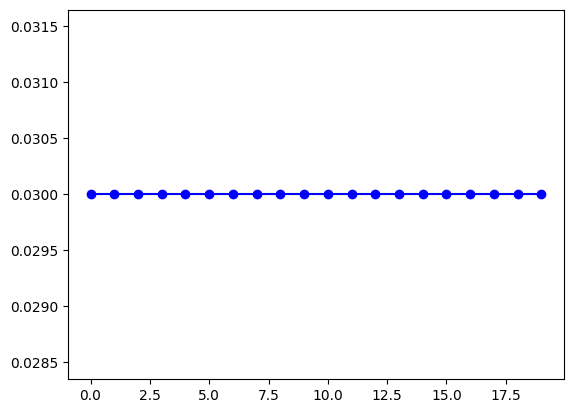

In [83]:
print(loss.shape)

mindex = np.argmin(loss, axis=1)

best_val = [search_locs[mindex[i]] for i in mindex]

fig, ax = plt.subplots()
ax.plot(best_val, 'b-o')